# skin_benchmarks 数据集分析

##  我们使用PyOD工具包来完成本次的离群点分析任务，首先导入所有需要的函数库

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time
import numpy as np
from numpy import percentile
import pandas as pd

from scipy.io import loadmat

import warnings

warnings.filterwarnings("ignore")

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.example import visualize
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as PCA_d

## 1、认识数据集

### 压缩包里的benchmarks文件夹里包含许多csv文件，每个benchmark对应每个因子的一个级别。 对于mother set，我们遍历问题维度级别的所有组合，并构建具有这些设置的5个benchmarks。某些mother set的局限性意味着，对于每个所需设置，我们可能无法获得5个数据集。
### 首先看一下整体的数据情况

In [2]:
df = pd.read_csv('/home/ubuntu/lh/liuhao/data/skin/meta_data/skin.preproc.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   point.id        245057 non-null  object 
 1   motherset       245057 non-null  object 
 2   origin          245057 non-null  object 
 3   original.label  245057 non-null  int64  
 4   ground.truth    245057 non-null  object 
 5   R               245057 non-null  float64
 6   G               245057 non-null  float64
 7   B               245057 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 15.0+ MB


,point.id,motherset,origin,original.label,ground.truth,R,G,B
0,skin_point_000001,skin,binary,1,anomaly,-0.820254,-0.792566,-0.002441
1,skin_point_000002,skin,binary,1,anomaly,-0.836317,-0.809249,-0.016223
2,skin_point_000003,skin,binary,1,anomaly,-0.852380,-0.825932,-0.030004
3,skin_point_000004,skin,binary,1,anomaly,-0.884505,-0.859298,-0.057567
4,skin_point_000005,skin,binary,1,anomaly,-0.884505,-0.859298,-0.057567


### 首先发现该数据集没有缺失值。数据集含有三个特征，注意原文说特征已经经过了标准化处理，具有了零均值和单位样本方差，所以后续离群点分析时不需要进行标准化处理了。在benchmarks文件夹中的文件会在后边添加一些噪声，相当于特征多了几列。
### 看一下benchmarks文件夹下所有文件的基本信息。

In [3]:
dir_path = '/home/ubuntu/lh/liuhao/data/skin/benchmarks'
file_list = os.listdir(dir_path)
file_list.sort()

all_column = np.zeros(len(file_list))
for i, name in enumerate(file_list):
    file = pd.read_csv(os.path.join(dir_path, name))
    shape = file.columns.values.shape[0]
    all_column[i] = shape

print(np.unique(all_column))

[ 9. 10. 12. 17.]


### 可见所有的文件根据特征数量可分为4类，打开文件可以发现，多出来的特征是额外添加的噪声。

## 2、离群点分析

### 之后，我们就要进行离群点分析的任务了。我们选择八种离群点检测算法，分别是:
1、异常值检测的线性模型：
(1) PCA：主成分分析（使用到特征向量超平面的加权投影距离之和作为离群值得分）
(2) MCD：最小协方差行列式（使用马哈拉诺比斯距离作为离群值）
(3) OCSVM：一类支持向量机

2、基于接近度的异常值检测模型：
(1) LOF：局部离群因子
(2) kNN：k最近邻（使用与第k个最近邻的距离作为离群值得分）
(3) HBOS：基于直方图的离群值得分

3、离群集成和组合框架
(1) IForest：隔离森林
(2) FB：Feature Bagging
### 有一些benchmarks比较奇怪，比如说离群点比例大于50%，此时我们在处理过程中需要把ground truth中的正常点和离群点标签互换，否则初始化检测工具的时候会出错，注意这并不会影响最终结果，因为正常点和离群点都是相对的。还有一些benchmarks含有非常少的离群点，会导致测试集中不含有离群点，这时我们需要重新划分测试集。一些实现过程中的细节请看代码注释。

In [4]:
# %%capture result

random_state = np.random.RandomState(42)

df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'FB', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD',
              'OCSVM', 'PCA']

roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)

for name in file_list:
    print("... Processing", name, '...')
    file = pd.read_csv(os.path.join(dir_path, name))

    X = file.values[:, 6:]
    y = (file.values[:, 5] == 'anomaly')+0
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)
    
        
    if outliers_fraction > 0.5:
        outliers_fraction = 1 - outliers_fraction
        y = 1 - y

    # 保存结果
    roc_list = [name[:-4], X.shape[0], X.shape[1], outliers_percentage]
    prn_list = [name[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [name[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 60% 训练集， 40% 测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=random_state)
    # 当测试集只含有一类时重新划分
    while (len(np.unique(y_test)) != 2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                            random_state=random_state)

    # 数据已经经过了标准化，直接传入就行
    X_train_norm, X_test_norm = X_train, X_test
    
    # 定义八种离群值检测工具进行比较
    classifiers = {
        'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                          random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(
            contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,
                                    random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(
            contamination=outliers_fraction),
        'Minimum Covariance Determinant (MCD)': MCD(
            contamination=outliers_fraction, random_state=random_state),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction, random_state=random_state),
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)
        time_list.append(duration)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

#         print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
#               'execution time: {duration}s'.format(
#             clf_name=clf_name, roc=roc, prn=prn, duration=duration))

        roc_list.append(roc)
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)
    
print('Done!')

... Processing skin_benchmark_0001.csv ...
... Processing skin_benchmark_0002.csv ...
... Processing skin_benchmark_0003.csv ...
... Processing skin_benchmark_0004.csv ...
... Processing skin_benchmark_0005.csv ...
... Processing skin_benchmark_0006.csv ...
... Processing skin_benchmark_0007.csv ...
... Processing skin_benchmark_0008.csv ...
... Processing skin_benchmark_0009.csv ...
... Processing skin_benchmark_0010.csv ...
... Processing skin_benchmark_0011.csv ...
... Processing skin_benchmark_0012.csv ...
... Processing skin_benchmark_0013.csv ...
... Processing skin_benchmark_0014.csv ...
... Processing skin_benchmark_0015.csv ...
... Processing skin_benchmark_0016.csv ...
... Processing skin_benchmark_0017.csv ...
... Processing skin_benchmark_0018.csv ...
... Processing skin_benchmark_0019.csv ...
... Processing skin_benchmark_0020.csv ...
... Processing skin_benchmark_0021.csv ...
... Processing skin_benchmark_0022.csv ...
... Processing skin_benchmark_0023.csv ...
... Process

... Processing skin_benchmark_0192.csv ...
... Processing skin_benchmark_0193.csv ...
... Processing skin_benchmark_0194.csv ...
... Processing skin_benchmark_0195.csv ...
... Processing skin_benchmark_0196.csv ...
... Processing skin_benchmark_0197.csv ...
... Processing skin_benchmark_0198.csv ...
... Processing skin_benchmark_0199.csv ...
... Processing skin_benchmark_0200.csv ...
... Processing skin_benchmark_0201.csv ...
... Processing skin_benchmark_0202.csv ...
... Processing skin_benchmark_0203.csv ...
... Processing skin_benchmark_0204.csv ...
... Processing skin_benchmark_0205.csv ...
... Processing skin_benchmark_0206.csv ...
... Processing skin_benchmark_0207.csv ...
... Processing skin_benchmark_0208.csv ...
... Processing skin_benchmark_0209.csv ...
... Processing skin_benchmark_0210.csv ...
... Processing skin_benchmark_0211.csv ...
... Processing skin_benchmark_0212.csv ...
... Processing skin_benchmark_0213.csv ...
... Processing skin_benchmark_0214.csv ...
... Process

... Processing skin_benchmark_0383.csv ...
... Processing skin_benchmark_0384.csv ...
... Processing skin_benchmark_0385.csv ...
... Processing skin_benchmark_0386.csv ...
... Processing skin_benchmark_0387.csv ...
... Processing skin_benchmark_0388.csv ...
... Processing skin_benchmark_0389.csv ...
... Processing skin_benchmark_0390.csv ...
... Processing skin_benchmark_0391.csv ...
... Processing skin_benchmark_0392.csv ...
... Processing skin_benchmark_0393.csv ...
... Processing skin_benchmark_0394.csv ...
... Processing skin_benchmark_0395.csv ...
... Processing skin_benchmark_0396.csv ...
... Processing skin_benchmark_0397.csv ...
... Processing skin_benchmark_0398.csv ...
... Processing skin_benchmark_0399.csv ...
... Processing skin_benchmark_0400.csv ...
... Processing skin_benchmark_0401.csv ...
... Processing skin_benchmark_0402.csv ...
... Processing skin_benchmark_0403.csv ...
... Processing skin_benchmark_0404.csv ...
... Processing skin_benchmark_0405.csv ...
... Process

... Processing skin_benchmark_0634.csv ...
... Processing skin_benchmark_0635.csv ...
... Processing skin_benchmark_0636.csv ...
... Processing skin_benchmark_0637.csv ...
... Processing skin_benchmark_0638.csv ...
... Processing skin_benchmark_0639.csv ...
... Processing skin_benchmark_0640.csv ...
... Processing skin_benchmark_0641.csv ...
... Processing skin_benchmark_0642.csv ...
... Processing skin_benchmark_0643.csv ...
... Processing skin_benchmark_0644.csv ...
... Processing skin_benchmark_0645.csv ...
... Processing skin_benchmark_0646.csv ...
... Processing skin_benchmark_0647.csv ...
... Processing skin_benchmark_0648.csv ...
... Processing skin_benchmark_0649.csv ...
... Processing skin_benchmark_0650.csv ...
... Processing skin_benchmark_0651.csv ...
... Processing skin_benchmark_0652.csv ...
... Processing skin_benchmark_0653.csv ...
... Processing skin_benchmark_0654.csv ...
... Processing skin_benchmark_0655.csv ...
... Processing skin_benchmark_0656.csv ...
... Process

... Processing skin_benchmark_0825.csv ...
... Processing skin_benchmark_0826.csv ...
... Processing skin_benchmark_0827.csv ...
... Processing skin_benchmark_0828.csv ...
... Processing skin_benchmark_0829.csv ...
... Processing skin_benchmark_0830.csv ...
... Processing skin_benchmark_0831.csv ...
... Processing skin_benchmark_0832.csv ...
... Processing skin_benchmark_0833.csv ...
... Processing skin_benchmark_0834.csv ...
... Processing skin_benchmark_0835.csv ...
... Processing skin_benchmark_0836.csv ...
... Processing skin_benchmark_0837.csv ...
... Processing skin_benchmark_0838.csv ...
... Processing skin_benchmark_0839.csv ...
... Processing skin_benchmark_0840.csv ...
... Processing skin_benchmark_0901.csv ...
... Processing skin_benchmark_0902.csv ...
... Processing skin_benchmark_0903.csv ...
... Processing skin_benchmark_0904.csv ...
... Processing skin_benchmark_0905.csv ...
... Processing skin_benchmark_0906.csv ...
... Processing skin_benchmark_0907.csv ...
... Process

... Processing skin_benchmark_1076.csv ...
... Processing skin_benchmark_1077.csv ...
... Processing skin_benchmark_1078.csv ...
... Processing skin_benchmark_1079.csv ...
... Processing skin_benchmark_1080.csv ...
... Processing skin_benchmark_1081.csv ...
... Processing skin_benchmark_1082.csv ...
... Processing skin_benchmark_1083.csv ...
... Processing skin_benchmark_1084.csv ...
... Processing skin_benchmark_1085.csv ...
... Processing skin_benchmark_1086.csv ...
... Processing skin_benchmark_1087.csv ...
... Processing skin_benchmark_1088.csv ...
... Processing skin_benchmark_1089.csv ...
... Processing skin_benchmark_1090.csv ...
... Processing skin_benchmark_1091.csv ...
... Processing skin_benchmark_1092.csv ...
... Processing skin_benchmark_1093.csv ...
... Processing skin_benchmark_1094.csv ...
... Processing skin_benchmark_1095.csv ...
... Processing skin_benchmark_1096.csv ...
... Processing skin_benchmark_1097.csv ...
... Processing skin_benchmark_1098.csv ...
... Process

... Processing skin_benchmark_1327.csv ...
... Processing skin_benchmark_1328.csv ...
... Processing skin_benchmark_1329.csv ...
... Processing skin_benchmark_1330.csv ...
... Processing skin_benchmark_1331.csv ...
... Processing skin_benchmark_1332.csv ...
... Processing skin_benchmark_1333.csv ...
... Processing skin_benchmark_1334.csv ...
... Processing skin_benchmark_1335.csv ...
... Processing skin_benchmark_1336.csv ...
... Processing skin_benchmark_1337.csv ...
... Processing skin_benchmark_1338.csv ...
... Processing skin_benchmark_1339.csv ...
... Processing skin_benchmark_1340.csv ...
... Processing skin_benchmark_1341.csv ...
... Processing skin_benchmark_1342.csv ...
... Processing skin_benchmark_1343.csv ...
... Processing skin_benchmark_1344.csv ...
... Processing skin_benchmark_1345.csv ...
... Processing skin_benchmark_1346.csv ...
... Processing skin_benchmark_1347.csv ...
... Processing skin_benchmark_1348.csv ...
... Processing skin_benchmark_1349.csv ...
... Process

... Processing skin_benchmark_1578.csv ...
... Processing skin_benchmark_1579.csv ...
... Processing skin_benchmark_1580.csv ...
... Processing skin_benchmark_1581.csv ...
... Processing skin_benchmark_1582.csv ...
... Processing skin_benchmark_1583.csv ...
... Processing skin_benchmark_1584.csv ...
... Processing skin_benchmark_1585.csv ...
... Processing skin_benchmark_1586.csv ...
... Processing skin_benchmark_1587.csv ...
... Processing skin_benchmark_1588.csv ...
... Processing skin_benchmark_1589.csv ...
... Processing skin_benchmark_1590.csv ...
... Processing skin_benchmark_1591.csv ...
... Processing skin_benchmark_1592.csv ...
... Processing skin_benchmark_1593.csv ...
... Processing skin_benchmark_1594.csv ...
... Processing skin_benchmark_1595.csv ...
... Processing skin_benchmark_1596.csv ...
... Processing skin_benchmark_1597.csv ...
... Processing skin_benchmark_1598.csv ...
... Processing skin_benchmark_1599.csv ...
... Processing skin_benchmark_1600.csv ...
... Process

### 我们列出所有文件的处理时间

In [5]:
print('Time complexity')
time_df.to_csv("skin_time.csv")
time_df

Time complexity


,Data,#Samples,# Dimensions,Outlier Perc,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,skin_benchmark_0001,6000,3,20.2833,0.2637,2.0738,0.5317,0.2621,0.0374,0.9543,1.2287,0.0036
0,skin_benchmark_0002,6000,3,20.4167,0.2756,0.0026,0.5241,0.2643,0.0366,0.9434,0.6114,0.0032
0,skin_benchmark_0003,6000,3,20.75,0.2553,0.0026,0.5094,0.2598,0.0386,0.9563,0.6416,0.003
0,skin_benchmark_0004,6000,3,19.7833,0.2418,0.0025,0.4625,0.2261,0.0376,0.9618,0.7039,0.0031
0,skin_benchmark_0005,6000,3,20.6833,0.2556,0.0025,0.4632,0.2226,0.0309,0.9419,0.7298,0.0038
...,...,...,...,...,...,...,...,...,...,...,...,...
0,skin_benchmark_1736,6000,11,10,2.9511,0.0081,0.5114,0.6042,0.4629,2.1781,0.7747,0.0085
0,skin_benchmark_1737,6000,11,10,3.1525,0.008,0.5135,0.606,0.4693,2.109,0.7697,0.0096
0,skin_benchmark_1738,6000,11,10,1.9069,0.0081,0.5067,0.611,0.4774,2.2835,0.7717,0.009
0,skin_benchmark_1739,6000,11,10,2.9914,0.0078,0.5078,0.6065,0.4638,1.75,0.7825,0.009


### 列出所有文件用所有检测器处理结果的ROC

In [6]:
print('ROC Performance')
roc_df.to_csv("skin_roc.csv")
roc_df

ROC Performance


,Data,#Samples,# Dimensions,Outlier Perc,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,skin_benchmark_0001,6000,3,20.2833,0.4145,0.6132,0.6768,0.7134,0.378,0.8897,0.5581,0.4597
0,skin_benchmark_0002,6000,3,20.4167,0.4521,0.5562,0.6554,0.7088,0.4247,0.8912,0.5393,0.45
0,skin_benchmark_0003,6000,3,20.75,0.4208,0.5781,0.6386,0.7166,0.405,0.8917,0.5424,0.4444
0,skin_benchmark_0004,6000,3,19.7833,0.4685,0.5804,0.6965,0.717,0.4201,0.8892,0.5673,0.4759
0,skin_benchmark_0005,6000,3,20.6833,0.4446,0.5861,0.6649,0.7175,0.4114,0.8977,0.5635,0.4558
...,...,...,...,...,...,...,...,...,...,...,...,...
0,skin_benchmark_1736,6000,11,10,0.3998,0.4716,0.4004,0.4532,0.4165,0.3457,0.3785,0.3786
0,skin_benchmark_1737,6000,11,10,0.4159,0.4488,0.4225,0.461,0.4285,0.3443,0.391,0.3836
0,skin_benchmark_1738,6000,11,10,0.3805,0.4398,0.3865,0.4543,0.4034,0.3461,0.3611,0.3637
0,skin_benchmark_1739,6000,11,10,0.4186,0.428,0.3857,0.4508,0.4121,0.3462,0.3584,0.3604


### 列出所有文件用所有检测器处理结果的prn

In [7]:
print('Precision @ n Performance')
prn_df.to_csv("skin_prn.csv")
prn_df

Precision @ n Performance


,Data,#Samples,# Dimensions,Outlier Perc,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,skin_benchmark_0001,6000,3,20.2833,0.1565,0.1922,0.1565,0.2215,0.1098,0.5752,0.2053,0.0244
0,skin_benchmark_0002,6000,3,20.4167,0.2065,0.166,0.1275,0.2308,0.0992,0.5789,0.2004,0.0547
0,skin_benchmark_0003,6000,3,20.75,0.1196,0.1688,0.0619,0.2206,0.0825,0.5773,0.1711,0.033
0,skin_benchmark_0004,6000,3,19.7833,0.2004,0.1418,0.1343,0.2047,0.1045,0.548,0.1812,0.0192
0,skin_benchmark_0005,6000,3,20.6833,0.1615,0.1683,0.1401,0.2665,0.1031,0.6226,0.2237,0.0642
...,...,...,...,...,...,...,...,...,...,...,...,...
0,skin_benchmark_1736,6000,11,10,0.0588,0.0706,0.0627,0.0667,0.0667,0.0039,0.0549,0.0471
0,skin_benchmark_1737,6000,11,10,0.0422,0.0633,0.0338,0.0422,0.0295,0,0.0211,0.0211
0,skin_benchmark_1738,6000,11,10,0.0543,0.0853,0.0465,0.0543,0.0349,0,0.0271,0.031
0,skin_benchmark_1739,6000,11,10,0.0667,0.0958,0.0542,0.0583,0.0417,0,0.0292,0.025


### 下面对这三个结果进行分析，首先定义一个找最值的函数。

In [8]:
def get_extremum(value):
    mapp = ['FB', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD', 'OCSVM', 'PCA']
    
    max_i = np.argmax(value,axis=1)
    max_freq = dict(pd.Series(max_i).value_counts())
    pos_a = max(max_freq, key=max_freq.get)
    
    min_i = np.argmin(value,axis=1)
    min_freq = dict(pd.Series(min_i).value_counts())
    pos_i = max(min_freq, key=min_freq.get)
    
    print('含有最大值次数最多的检测器为：{}，含有最小值次数最多的检测器为：{}'.format(mapp[pos_a], mapp[pos_i]))

In [9]:
get_extremum(time_df.values[:,4:])

含有最大值次数最多的检测器为：MCD，含有最小值次数最多的检测器为：HBOS


### 可见，最耗时的检测器为MCD，最省时的检测器为HBOS

In [10]:
get_extremum(roc_df.values[:,4:])

含有最大值次数最多的检测器为：MCD，含有最小值次数最多的检测器为：PCA


### ROC值最大的检测器为MCD，最小的检测器为PCA

In [11]:
get_extremum(prn_df.values[:,4:])

含有最大值次数最多的检测器为：FB，含有最小值次数最多的检测器为：FB


### 对于精确度来说，最好的和最坏的都是FB，这证明FB算法可能受数据集特征影响比较大，我们对它进行进一步分析。

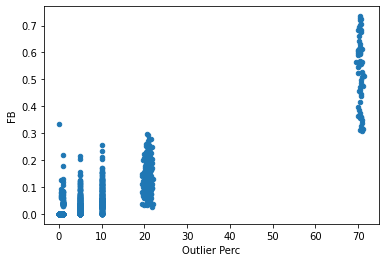

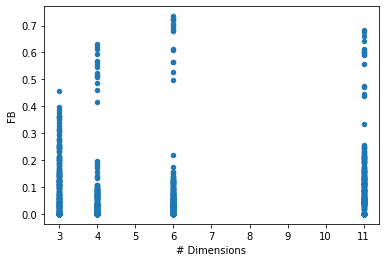

In [12]:
prn_df.plot.scatter(x='Outlier Perc', y='FB')
prn_df.plot.scatter(x='# Dimensions', y='FB')

### 从上图可以看出，FB的结果和异常值比例关联较大，和特征维度关系不是非常明显。基本来说，异常值的增多会使得FB算法的精确度提高。

## 3、结果可视化

### 这一节，我们选择一个benchmark对八种离群点检测算法进行结果可视化。由于特征维度大于2，我们必须使用降维策略。后续使用了两种降维策略，分别是TSNE和PCA，我们可以直观感受下哪种策略可视化效果好。

### (1) TSNE降维


... Processing skin_benchmark_0001.csv ...
0.20283333333333334
Feature Bagging ROC:0.3875, precision @ rank n:0.0846, execution time: 0.0173s


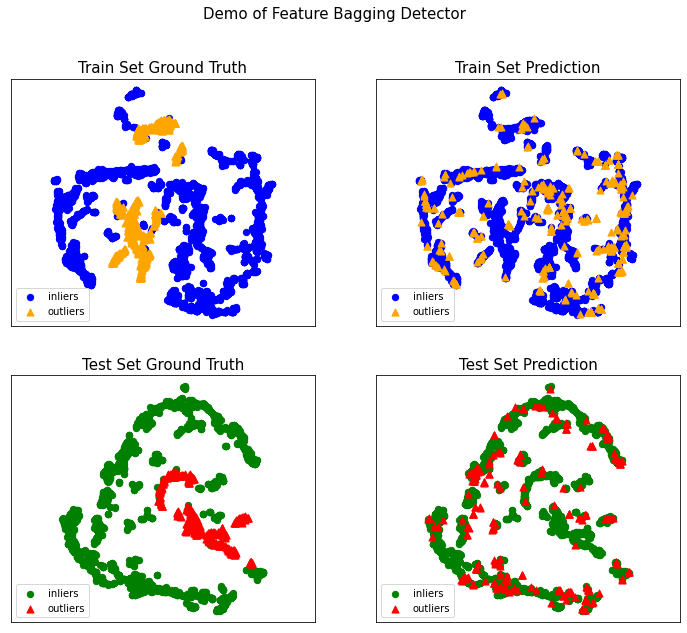

Histogram-base Outlier Detection (HBOS) ROC:0.5724, precision @ rank n:0.1887, execution time: 0.0173s


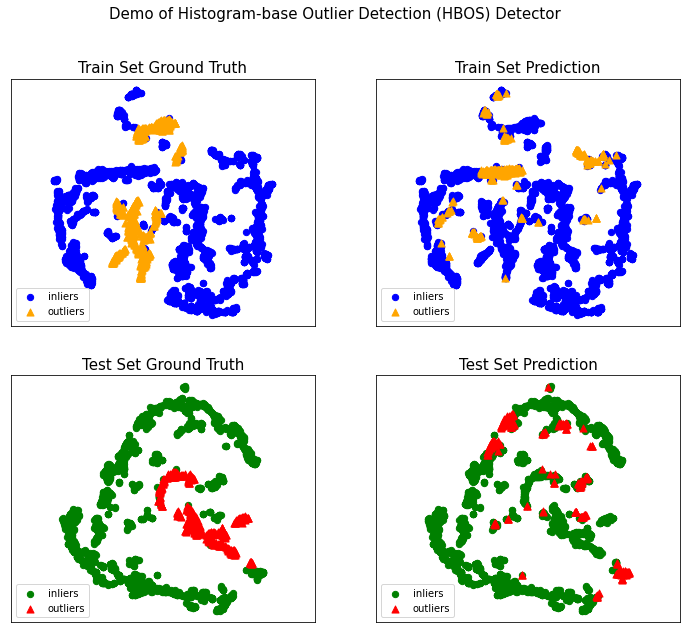

Isolation Forest ROC:0.6855, precision @ rank n:0.1121, execution time: 0.0173s


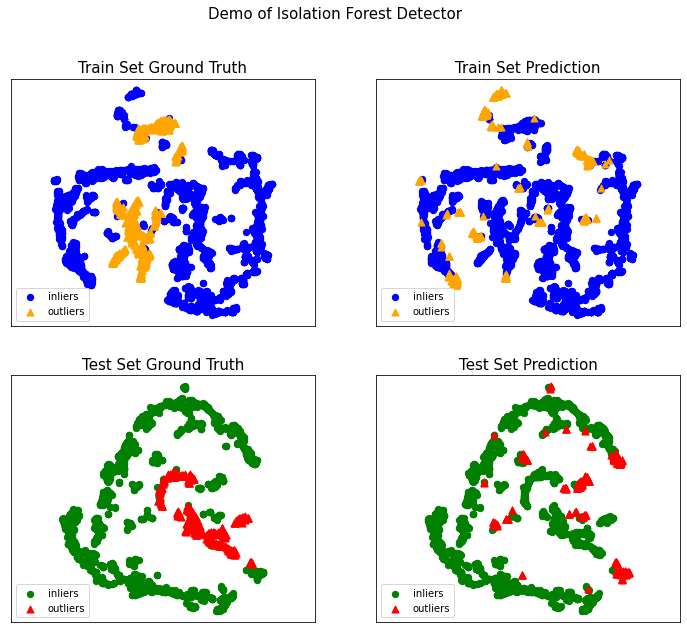

K Nearest Neighbors (KNN) ROC:0.7107, precision @ rank n:0.1734, execution time: 0.0173s


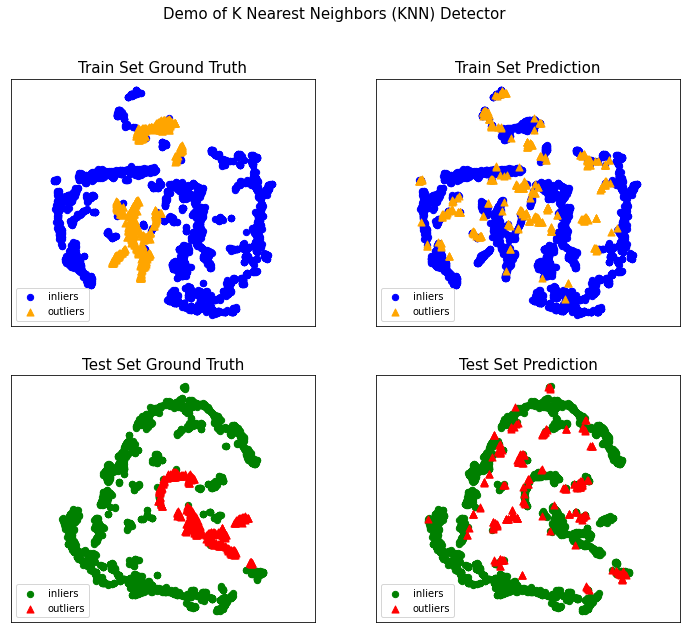

Local Outlier Factor (LOF) ROC:0.4011, precision @ rank n:0.1057, execution time: 0.0173s


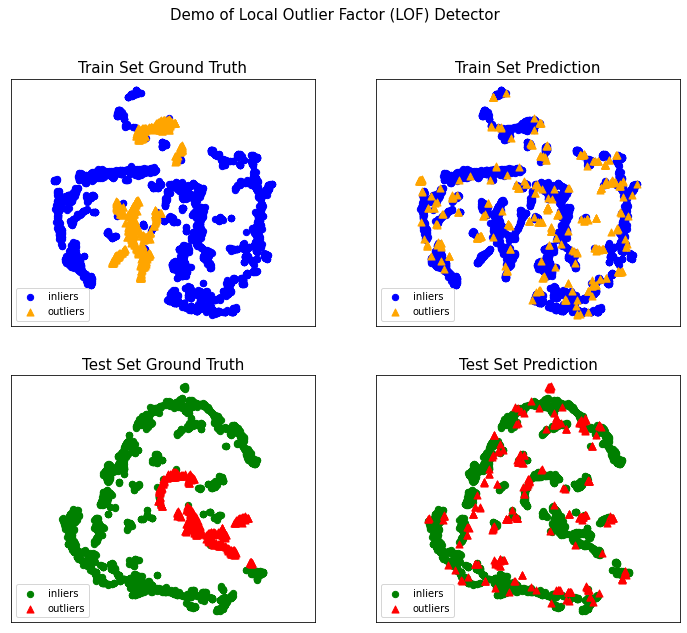

Minimum Covariance Determinant (MCD) ROC:0.8911, precision @ rank n:0.5687, execution time: 0.0173s


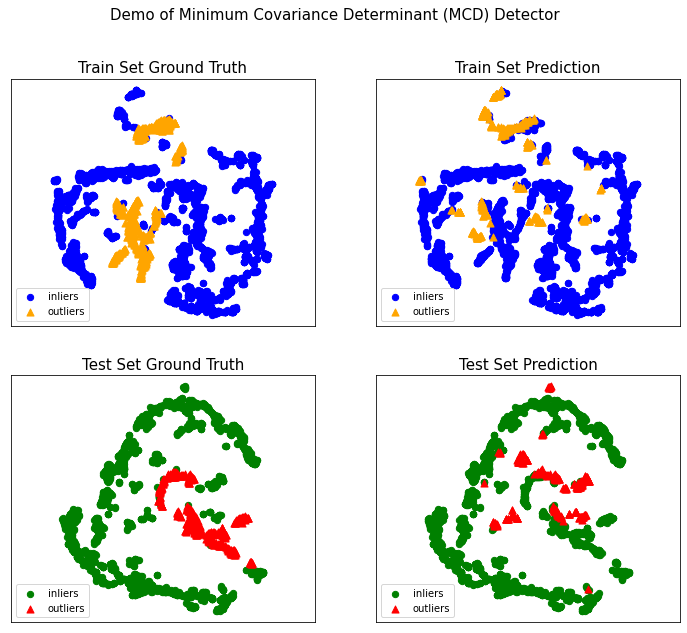

One-class SVM (OCSVM) ROC:0.5535, precision @ rank n:0.1522, execution time: 0.0173s


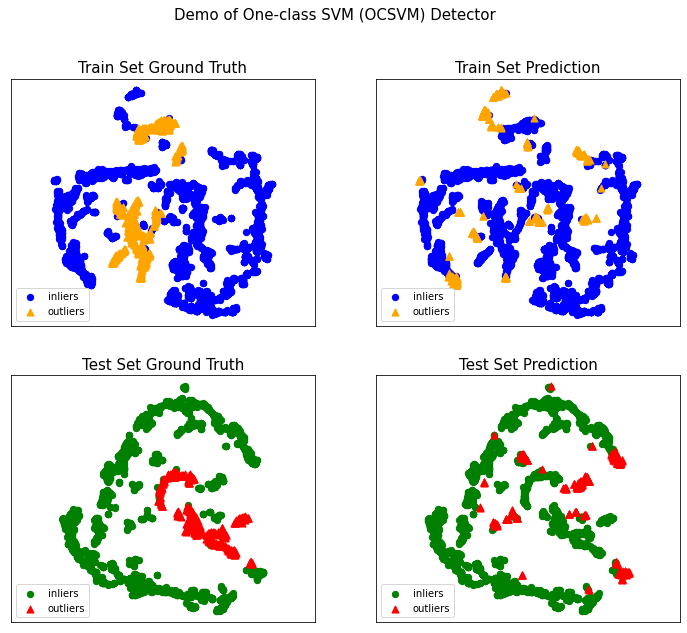

Principal Component Analysis (PCA) ROC:0.4532, precision @ rank n:0.0317, execution time: 0.0173s


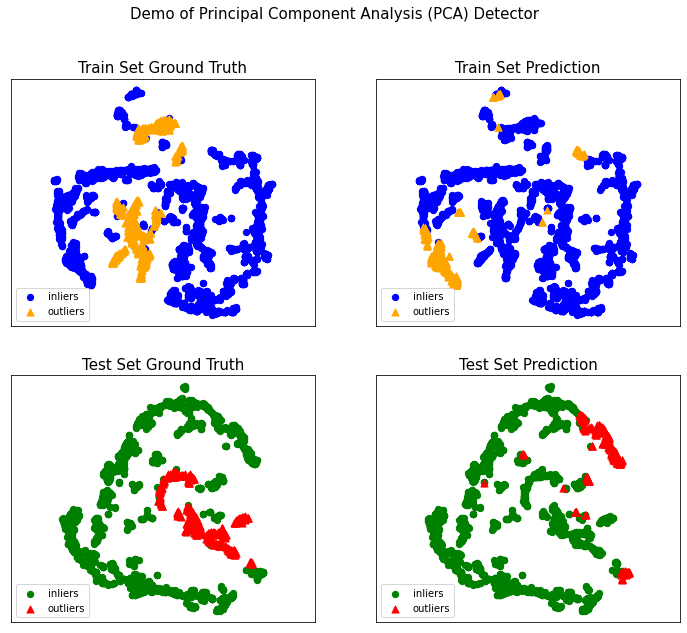

In [13]:
print("\n... Processing", 'skin_benchmark_0001.csv', '...')
file = pd.read_csv(os.path.join(dir_path, 'skin_benchmark_0001.csv'))

X = file.values[:, 6:]
y = (file.values[:, 5] == 'anomaly')+0
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)
print(outliers_fraction)


if outliers_fraction > 0.5:
    outliers_fraction = 1 - outliers_fraction
    y = 1 - y

# 60% 训练集， 40% 测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=random_state)
# 当测试集只含有一类时重新划分
while (len(np.unique(y_test)) != 2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                        random_state=random_state)
    
# 数据已经经过了标准化，直接传入就行
X_train_norm, X_test_norm = X_train, X_test

X_train_tsne = TSNE(n_components=2)
X_train_tsne.fit_transform(X_train)
X_test_tsne = TSNE(n_components=2)
X_test_tsne.fit_transform(X_test)

for clf_name, clf in classifiers.items():
    clf.fit(X_train_norm)
    test_scores = clf.decision_function(X_test_norm)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    
    roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
    prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

    print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
          'execution time: {duration}s'.format(
        clf_name=clf_name, roc=roc, prn=prn, duration=duration))
    visualize(clf_name, X_train_tsne.embedding_, y_train, X_test_tsne.embedding_, y_test, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

### (2) PCA降维

Feature Bagging ROC:0.3882, precision @ rank n:0.0973, execution time: 0.0173s


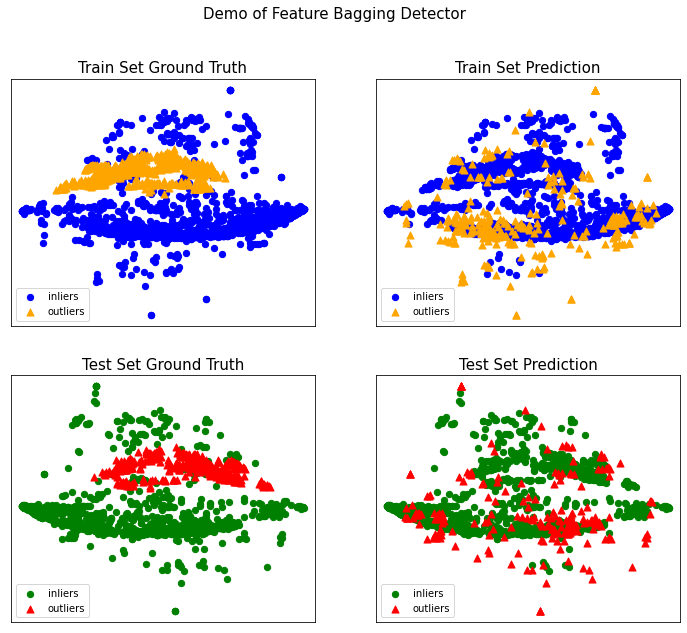

Histogram-base Outlier Detection (HBOS) ROC:0.5724, precision @ rank n:0.1887, execution time: 0.0173s


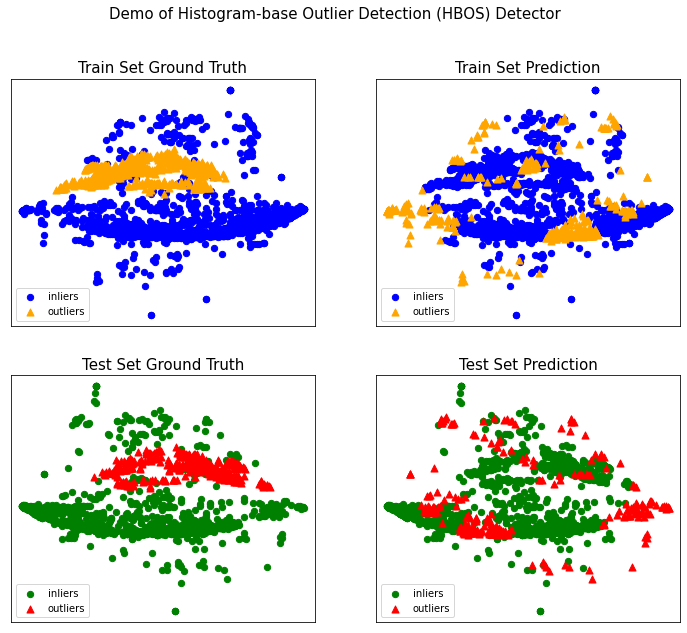

Isolation Forest ROC:0.6547, precision @ rank n:0.087, execution time: 0.0173s


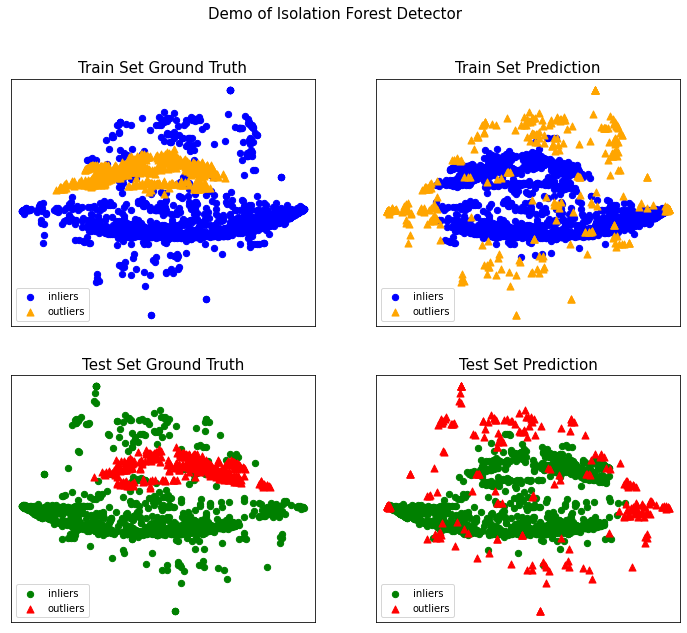

K Nearest Neighbors (KNN) ROC:0.7107, precision @ rank n:0.1734, execution time: 0.0173s


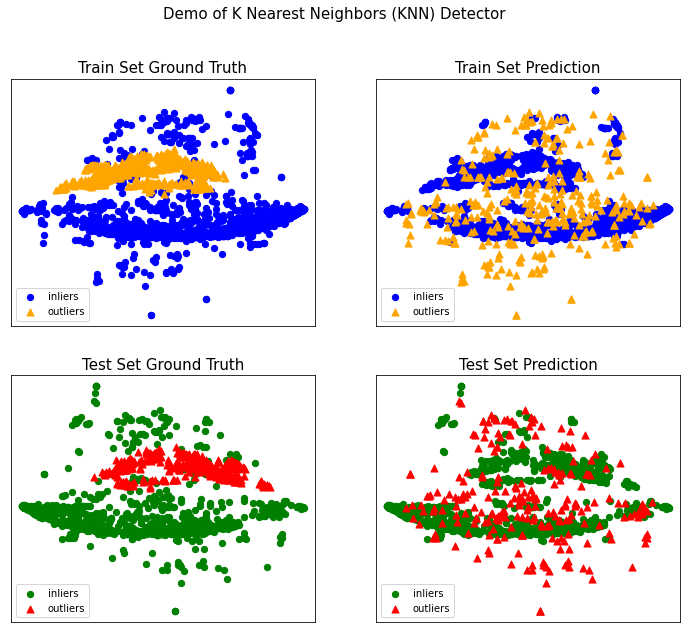

Local Outlier Factor (LOF) ROC:0.4011, precision @ rank n:0.1057, execution time: 0.0173s


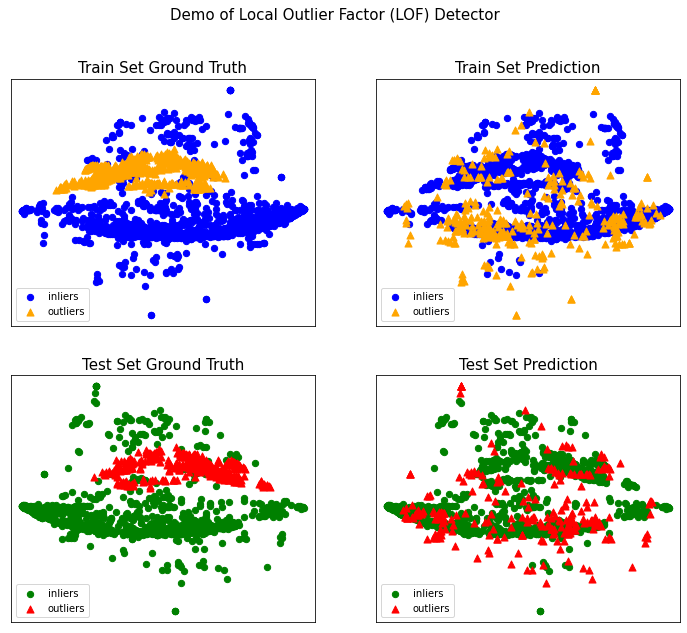

Minimum Covariance Determinant (MCD) ROC:0.8911, precision @ rank n:0.5687, execution time: 0.0173s


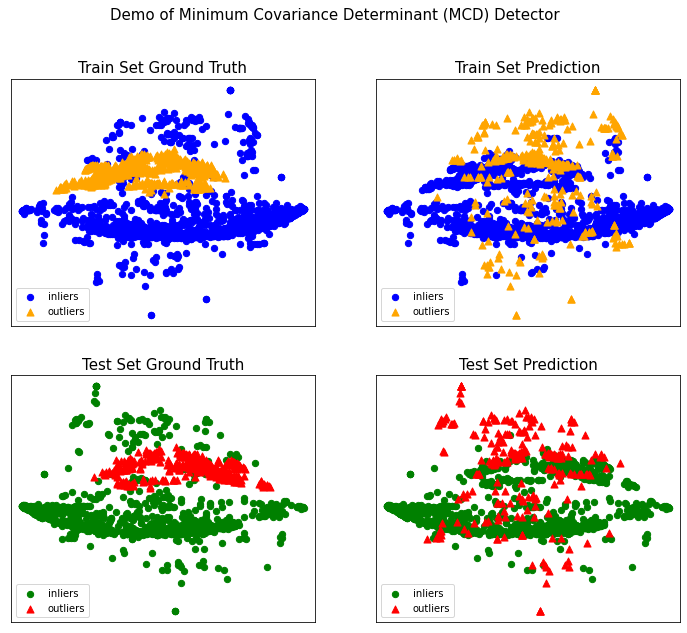

One-class SVM (OCSVM) ROC:0.5535, precision @ rank n:0.1522, execution time: 0.0173s


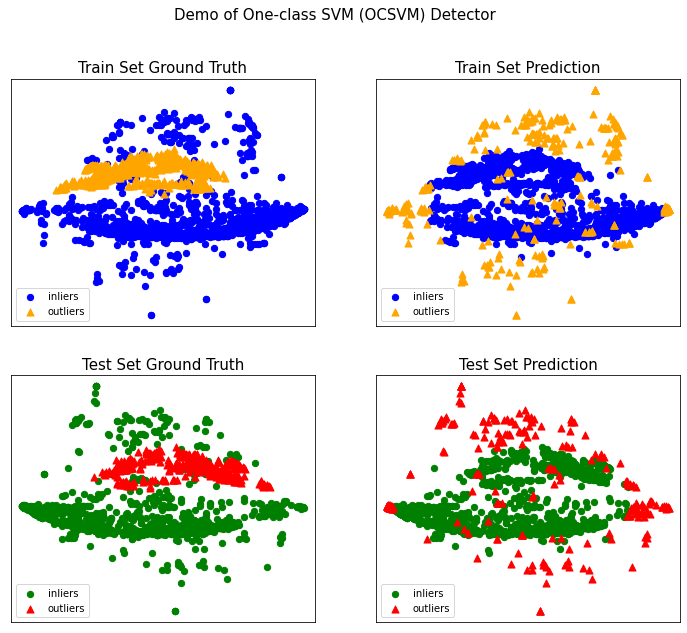

Principal Component Analysis (PCA) ROC:0.4532, precision @ rank n:0.0317, execution time: 0.0173s


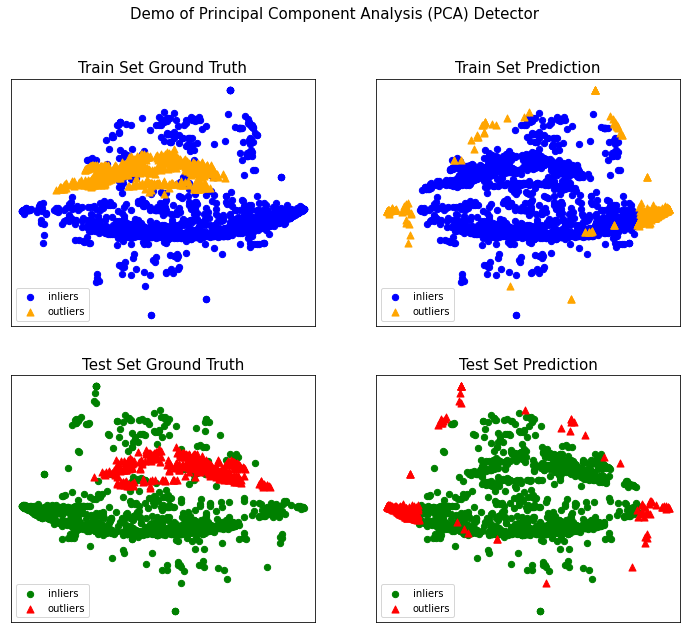

In [14]:
pca = PCA_d(n_components=2)                        #加载PCA算法，设置降维后主成分数为2
X_train_PCA = pca.fit_transform(X_train)  
pca_test = PCA_d(n_components=2)
X_test_PCA = pca_test.fit_transform(X_test)
for clf_name, clf in classifiers.items():
    clf.fit(X_train_norm)
    test_scores = clf.decision_function(X_test_norm)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    
    roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
    prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

    print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
          'execution time: {duration}s'.format(
        clf_name=clf_name, roc=roc, prn=prn, duration=duration))
    visualize(clf_name, X_train_PCA, y_train, X_test_PCA, y_test, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

### 从结果可以看出，似乎两种可视化方法都表明MCD的效果相对好一点，不论是训练集还是测试集，拟合出的离群点都和ground truth非常相像。至于两种可视化方法，似乎各有千秋，不过TSNE属于非线性降维，是一种流形学习方法，普遍认为效果会更好一点。

## 以上就是我使用八种离群点分析算法对该数据集进行处理的过程。